# Example 8.3: Resampling of signals


## Change of sample rate

Resampling is the process of changing the sampling rate of a signal after it has been measured. There are a few reasons why this operation often is performed:

- **Standardization**: when multiple data sources are measured at different sample rates, it is sometimes desired to resample all the data to a common sample rate.

- **Compression**: if the original sample rate is excessively high, converting to a smaller sample rate will reduce the data size and improve further data processing efficiency.

- **Compatibility**: certain analysis techniques where the data is utilised may require data to be at a specific sample rate.

We will demonstrate how to resample using Scipy in Python.

It is important to keep in mind that the Nyquist-Shannon theorem still applies, which states that to accurately sample a continuous signal without losing information, the sampling frequency must be at least twice the highest frequency component of the signal.


## Original signal

We consider a signal consisting of two sine waves:

$$
x(t)=A_1 \sin( 2 \pi f_1 t) + A_2 \sin( 2 \pi f_2 t)
$$

where $f_1=5$ Hz and $f_2=50$ Hz. 

We first sample this signal with a sample rate of $f_s=400$ Hz. This rate leads to a Nyquist rate of $f_s/2=200$ Hz. Both the excitation frequencies are below the Nyquist rate, so they are captured without issues.



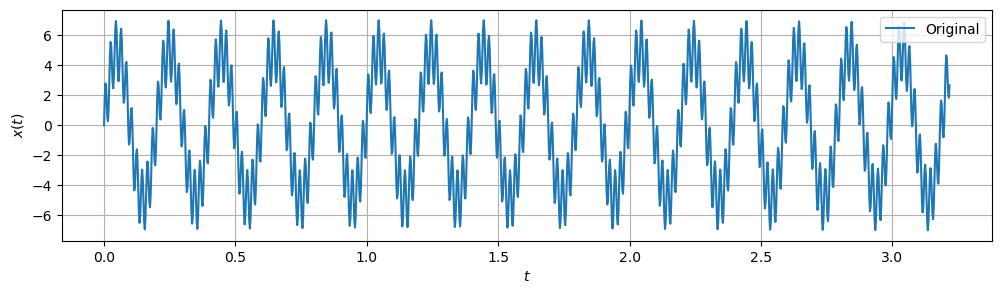

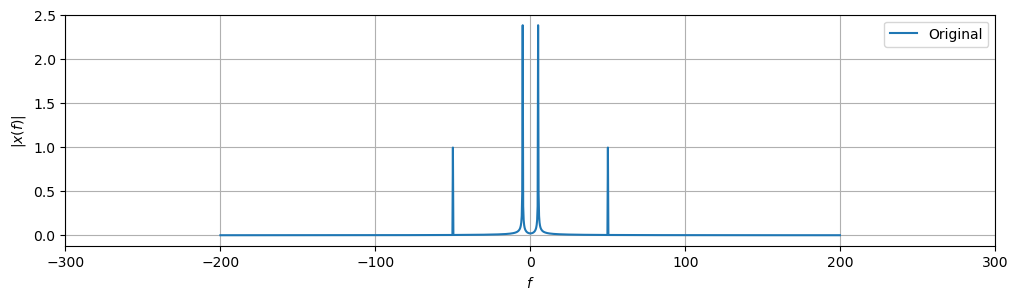

In [28]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as spsi

# Parameters for the original signal
fs = 400  # Original sampling rate in Hz
dt=1/fs
T=3.22

N=np.ceil(T/dt)

t=np.arange(0,N,1)*dt

N=len(t)

f1 = 5.02  # Frequency in Hz
f2 = 50  # Frequency in Hz
A1 = 5  # Amplitude 
A2 = 2  # Frequency of the sine wave in Hz

# Generate the sine wave
x1 = A1*np.sin(2*np.pi*f1*t)
x2 = A2*np.sin(2*np.pi*f2*t)

x=x1+x2+np.random.randn(len(t))*0.00

# Plot the original signal
plt.figure(figsize=(12, 3))
plt.plot(t, x, label='Original')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.grid()
plt.legend()

x_fft =  np.fft.fftshift(np.fft.fft(x))/N # DFT
f_fft = np.fft.fftshift(np.fft.fftfreq(N, d=dt)) # Frequency axis in Hz

plt.figure(figsize=(12, 3))
plt.plot(f_fft,np.abs(x_fft),label='Original')
plt.xlim(-300,300)
plt.ylabel(r'$|x(f)|$')
plt.xlabel(r'$f$')
plt.legend()
#plt.yscale('log')
plt.grid()


## Naive interpolation

We now consider a new, lower sample rate $f_s^{(new)}$. This leads to a new time step $\Delta t^{(new)}$ and a new time axis:

$$
t^{(new)}=[0,
\: \Delta t^{(new)}, 
\: 2 \Delta t^{(new)}, 
\: 3 \Delta t^{(new)}, 
\: \dots
]
$$

We first try to use linear interpolation between the original data points to resample to the new time axis.

We will try to set $f_s^{(new)}$ to $200$ Hz and $80$ Hz.


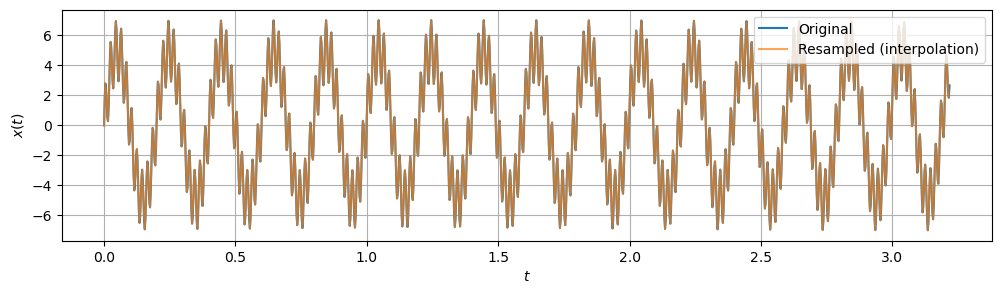

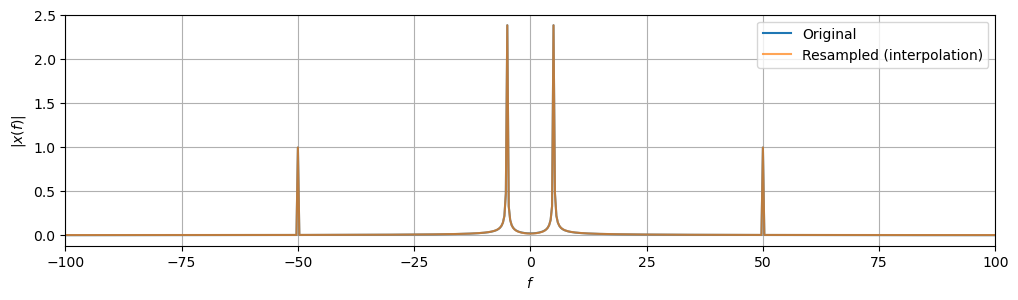

In [30]:
# Resample the signal to a lower sampling rate

fs_new = 200  # New sampling rate in Hz

dt_new=1/fs_new # New time step

N_new=int(np.ceil(T/dt_new)) # New number of samples

t_new=np.arange(0,N_new,1)*dt_new # New time axis

# Interpolate the signal
x_new= np.interp(t_new,t,x)

# Plot the resampled signal
plt.figure(figsize=(12, 3))
plt.plot(t, x, label='Original')
plt.plot(t_new, x_new, label='Resampled (interpolation)', alpha=0.7)
plt.ylabel('$x(t)$')
plt.xlabel(r'$t$')
plt.grid(True)
plt.legend()
plt.show()

x_fft_new =  np.fft.fftshift(np.fft.fft(x_new))/N_new # DFT
f_fft_new = np.fft.fftshift(np.fft.fftfreq(N_new, d=dt_new)) # Frequency axis in Hz

plt.figure(figsize=(12, 3))
plt.plot(f_fft,np.abs(x_fft),label='Original')
plt.plot(f_fft_new,np.abs(x_fft_new),label='Resampled (interpolation)', alpha=0.7)
plt.xlim(-100,100)
plt.ylabel(r'$|x(f)|$')
plt.xlabel(r'$f$')
plt.legend()
#plt.yscale('log')
plt.grid()

Although linear interpolation is not the best way to resample a vibration signal, setting $f_s^{(new)}$ to $200$ Hz works reasonably well.

For $f_s^{(new)}=80$ Hz, the are problems. This sample rate has a Nyquist rate of $40$ Hz, which cannot correctly capture the $50$ Hz component in the original signal. We therefore get aliasing: a false frequency component occurs at $30$ Hz.

If we want to resample to $80$ Hz, we have to first apply an anti-alias filter (lowpass filter) that removes all frequency content above the Nyquist rate.


## Using Scipy resample function

Python (and most other programming languages) has preprogrammed resample functions that take into account the potential problem of aliasing.

We can use the Scipy function *resample_poly*, which has a built-in zero-phase low-pass filter.

The function first upsamples the signal by a factor of $n_1$ and downsamples it by $n_2$. For a conversion from $400$ to $80$ Hz:

$$
\dfrac{n_1}{n_2}=
\dfrac{80}{400}=
\dfrac{1}{5}
$$

We must specify to upsample by a factor of 1 (so no upsampling) and then downsample by a factor of 5 (keep every 5th data point).



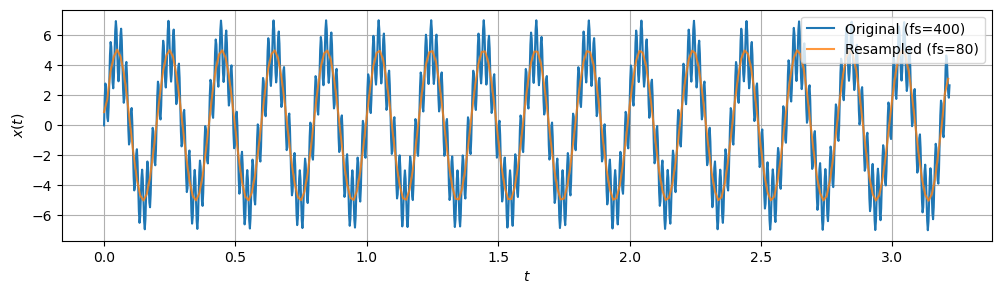

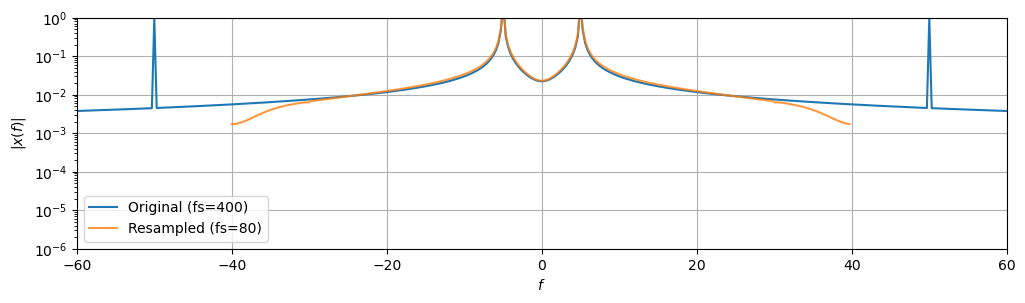

In [34]:
# Resample the signal to a lower sampling rate

fs_new = 80  # New sampling rate in Hz

dt_new=1/fs_new # New time step

N_new=int(np.ceil(T/dt_new)) # New number of samples

t_new=np.arange(0,N_new,1)*dt_new # New time axis

# Resample the signal
x_new=spsi.resample_poly(x, 1, 5,window=('kaiser', 5.0)) # Upsample 1, downsample 5, new rate: 400*1/5=80 Hz

# Plot the resampled signal
plt.figure(figsize=(12, 3))
plt.plot(t, x,label='Original (fs=' + str(fs) + ')')
plt.plot(t_new, x_new,label='Resampled (fs=' + str(fs_new) + ')' , alpha=0.8)
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.grid(True)
plt.legend()
plt.show()

x_fft_new =  np.fft.fftshift(np.fft.fft(x_new))/N_new # DFT
f_fft_new = np.fft.fftshift(np.fft.fftfreq(N_new, d=dt_new)) # Frequency axis in Hz

plt.figure(figsize=(12, 3))
plt.plot(f_fft,np.abs(x_fft),label='Original (fs=' + str(fs) + ')')
plt.plot(f_fft_new,np.abs(x_fft_new),label='Resampled (fs=' + str(fs_new) + ')' , alpha=0.8)
plt.xlim(-60,60)
plt.ylim(1e-6,1e0)
plt.ylabel(r'$|x(f)|$')
plt.xlabel(r'$f$')
plt.legend()
plt.yscale('log')
plt.grid()

The signal is successfully resampled without aliasing.

The cost of reducing the sample is that the frequency component at $50$ Hz is lost; it cannot be represented with a sample rate of $80$ Hz. The $5$ Hz component is preserved.




## Upsampling

Upsampling of a signal can be performed using the same function. We try to double the sample rate to $f_s^{(new)}=800$ Hz. 


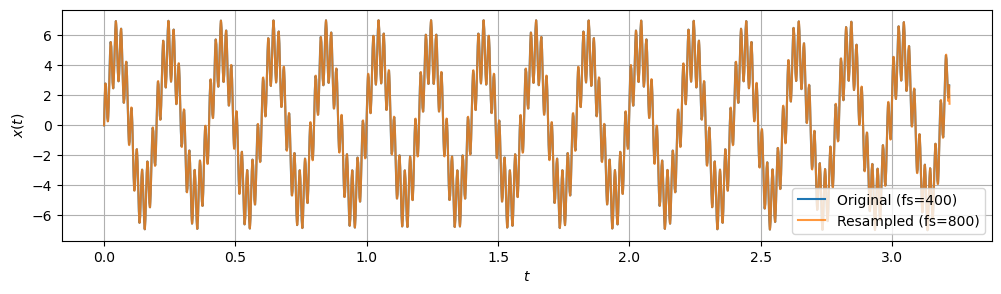

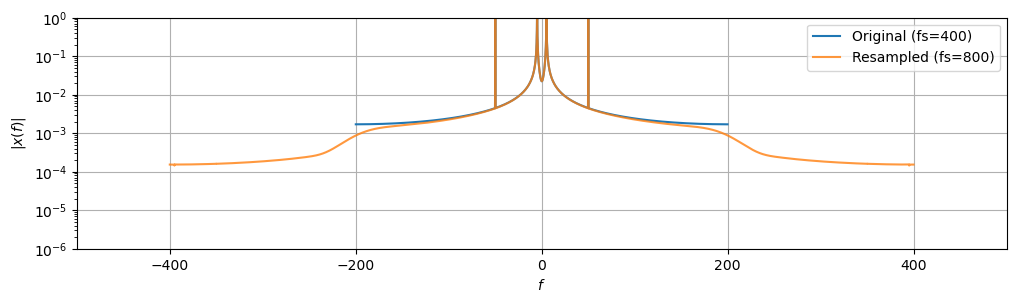

In [37]:
fs_new = 800  # New sampling rate in Hz

dt_new=1/fs_new # New time step

N_new=int(np.ceil(T/dt_new)) # New number of samples

t_new=np.arange(0,N_new,1)*dt_new # New time axis

# Resample the signal
x_new=spsi.resample_poly(x, 2, 1,window=('kaiser', 8.0)) # Upsample 2, downsample 1, new rate: 400*2/1=800 Hz

# Plot the resampled signal
plt.figure(figsize=(12, 3))
plt.plot(t, x,label='Original (fs=' + str(fs) + ')')
plt.plot(t_new, x_new,label='Resampled (fs=' + str(fs_new) + ')' , alpha=0.8)
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.grid(True)
plt.legend()
plt.show()

x_fft_new =  np.fft.fftshift(np.fft.fft(x_new))/N_new # DFT
f_fft_new = np.fft.fftshift(np.fft.fftfreq(N_new, d=dt_new)) # Frequency axis in Hz

plt.figure(figsize=(12, 3))
plt.plot(f_fft,np.abs(x_fft),label='Original (fs=' + str(fs) + ')')
plt.plot(f_fft_new,np.abs(x_fft_new),label='Resampled (fs=' + str(fs_new) + ')' , alpha=0.8)
plt.xlim(-500,500)
plt.ylim(1e-6,1e0)
plt.ylabel(r'$|x(f)|$')
plt.xlabel(r'$f$')
plt.legend()
plt.yscale('log')
plt.grid()


The operation is unproblematic. 

The new Nyquist rate is extended to $400$ Hz, but we can never reconstruct any frequency content from $200$ to $400$ Hz since this was an infeasible frequency region in the original signal.

